In [39]:
# note: fdfdpy and nonlinear_avm must be in PATH
from fdfdpy.Fdfd import Fdfd
from optimization import Optimization
from structures import three_port

import numpy as np
import matplotlib.pylab as plt
import scipy.sparse as sp

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
lambda0 = 2e-6
c0 = 3e8
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi)
dl = 0.4e-1                   # grid size (L0)
Nx = 200
Ny = 150
nx, ny = int(Nx/2), int(Ny/2)
shape = (Nx,Ny)           # shape of domain (in grids)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')

In [41]:
# define the two port parameters
L = 3
H = 3
w = .2
d = 1.5
# d = int(d/2/dl)*dl*2
eps_m = 5
spc = 1
l = 2

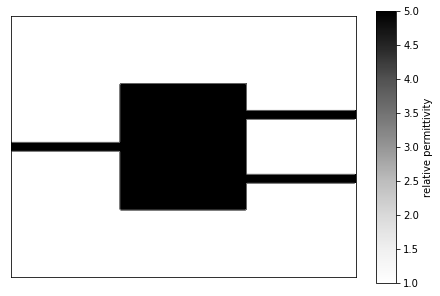

In [42]:
# define permittivity of three port system
eps_r = three_port(L, H, w, d, dl, l, spc, NPML, eps_start=5)
simulation = Fdfd(omega,eps_r,dl,NPML,pol)
simulation.plt_eps()
plt.show()

In [43]:
eps = simulation.eps_r
pts_in = np.sum(eps[30,:] > 1)
pts_top = np.sum(eps[Nx-30,:ny] > 1)
pts_bot = np.sum(eps[Nx-30,ny:] > 1)

print('waveguide has {} points in in port'.format(pts_in))
print('waveguide has {} points in top port'.format(pts_top))
print('waveguide has {} points in bottom port'.format(pts_bot))


waveguide has 5 points in in port
waveguide has 5 points in top port
waveguide has 5 points in bottom port


In [44]:
# set the modal source and probes

# simulation to solve
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(3.5, 'x', [30, ny], int(d/dl), scale=70)
simulation.setup_modes()
print('input power of {} W/L0'.format(simulation.W_in))
# top modal profile (kind of a hack, could be nice to get this without making a simulation())
top = Fdfd(omega, eps_r, dl, NPML, 'Ez')
top.add_mode(3.5, 'x', [Nx-30, ny+int(d/2/dl)], int(d/dl))
top.setup_modes()
J_top = np.abs(top.src)  # sometimes negative and sometimes positive. So I just abs it for consistency

# bottom modal profile
bot = Fdfd(omega, eps_r, dl, NPML, 'Ez')
bot.add_mode(3.5, 'x', [Nx-30, ny-int(d/2/dl)], int(d/dl))
bot.setup_modes()
J_bot = np.abs(bot.src)

input power of 9.821274878910922 W/L0


In [45]:
# set source and solve for electromagnetic fields
print('{} grids per wavelength'.format(int(lambda0/dl/1e-6)))
(Hx,Hy,Ez) = simulation.solve_fields()
print(np.max(np.abs(Ez_nl)))

50 grids per wavelength
165.1786750739863


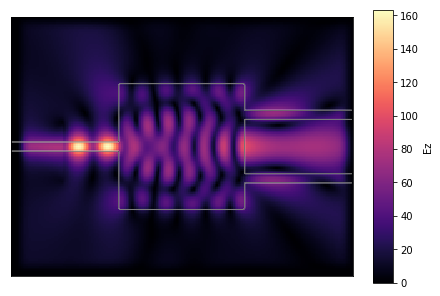

In [46]:
# plot linear field
simulation.plt_abs(outline=True, cbar=True);

In [47]:
# Define some parameters for the optimization
eps_max = 5
Nsteps = 100
Jregion = np.zeros(eps_r.shape)
Jregion[Nx-15, ny+int(d/2/dl)] = 1
Jregion_nl = np.zeros(eps_r.shape)
Jregion_nl[Nx-15, ny-int(d/2/dl)] = 1
chi3 = 2.8*1e-18                           # Silcion in m^2/V^2 from Boyd's book
chi3_fdfd = chi3/simulation.L0**2          # In the units of the FDFD solver such that eps_nl = eps_r + 3*chi3_fdfd*|e|^2

## Purely Linear

## Both Linear and Nonlinear

In [48]:
# define linear and nonlinear parts of objective function + the total objective function form
J = {}
J['linear']    = lambda e: np.sum(np.square(np.abs(e))*J_top)
J['nonlinear'] = lambda e: np.sum(np.square(np.abs(e))*J_bot)
J['total']     = lambda J_lin, J_nonlin: J_lin + J_nonlin

# define linear and nonlinear parts of dJdE + the total derivative form
dJdE = {}
dJdE['linear']    = lambda e: np.conj(e)*J_top
dJdE['nonlinear'] = lambda e: np.conj(e)*J_bot
dJdE['total']     = lambda dJdE_lin, dJdE_nonlin: dJdE_lin + dJdE_nonlin

# define the design and nonlinear regions
design_region = np.array(eps_r > 1).astype(int)
design_region[:nx-int(L/2/dl),:] = 0
design_region[nx+int(L/2/dl):,:] = 0
regions = {}
regions['design'] = design_region
regions['nonlin'] = design_region

# define the nonlinearity
kerr_nonlinearity = lambda e: 3*chi3_fdfd*np.square(np.abs(e))
kerr_nl_de = lambda e: 3*chi3_fdfd*np.conj(e)
nonlin_fns = {}
nonlin_fns['eps_nl'] = kerr_nonlinearity
nonlin_fns['dnl_de'] = kerr_nl_de

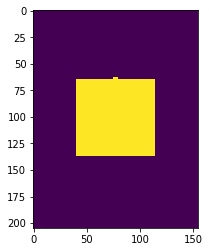

In [11]:
plt.imshow(design_region)

In [12]:
simulation.reset_eps(eps_r)

# initialize an optimization object with the optimization-specific parameters
opt_both = Optimization(Nsteps=100, J=J, dJdE=dJdE, eps_max=5, step_size=.1, solver='newton', opt_method='adam')

# run that optimization with the simulation and your objective function stuff
(new_eps) = opt_both.run(simulation, regions=regions, nonlin_fns=nonlin_fns)

100% (100 of 100) |######################| Elapsed Time: 0:08:11 ETA:  00:00:00

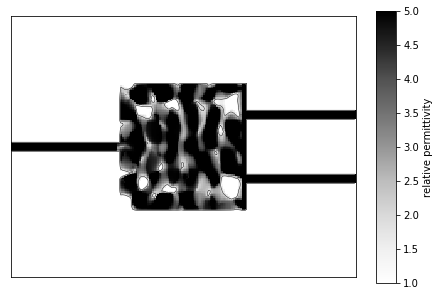

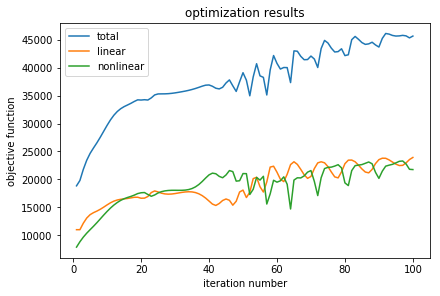

In [13]:
simulation.plt_eps()
plt.show()
opt_both.plt_objs()
plt.show()

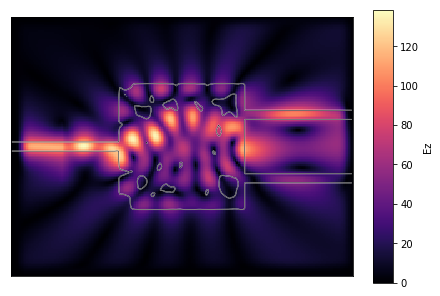

In [14]:
# compare the nonlinear and linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs()

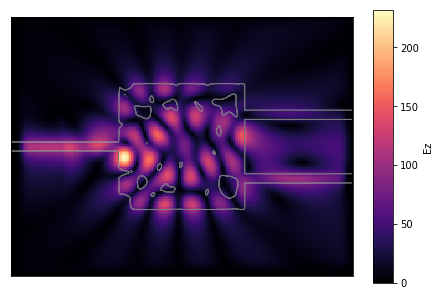

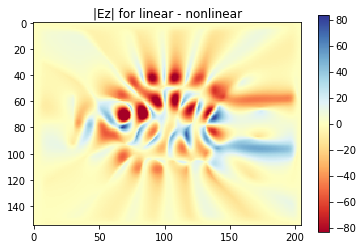

In [15]:
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
difference = np.abs(Ez).T - np.abs(Ez_nl).T
plt.imshow(difference, vmin=-np.max(difference), vmax=np.max(difference), cmap='RdYlBu')
plt.colorbar()
plt.title('|Ez| for linear - nonlinear')
plt.show()

In [53]:
from adjoint import dJdeps_nonlinear, dJdeps_linear
source_amp = 70
# Check the gradient with respect to one pixel in the design region
x_select = 71
y_select = 73

simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
(Hx,Hy,Ez,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
J1 = J['nonlinear'](Ez)

eps_r[(x_select, y_select)] += 1e-4
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
(Hx,Hy,Ez,_) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
J2 = J['nonlinear'](Ez)
grad_num = (J2 - J1)/1e-4

eps_r[(x_select, y_select)] -= 1e-4
grad_nl = dJdeps_nonlinear(simulation, design_region, J['nonlinear'], dJdE['nonlinear'],
                        nonlin_fns['eps_nl'], regions['nonlin'], nl_de=kerr_nl_de, 
                                               averaging=False)
grad_adj = grad_nl[(x_select, y_select)]
print(grad_num, grad_adj, np.linalg.norm(grad_num - grad_adj)/np.linalg.norm(grad_adj))

simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
(Hx,Hy,Ez) = simulation.solve_fields()
J1 = J['linear'](Ez)
grad_lin = dJdeps_linear(simulation, design_region, J['linear'], dJdE['linear'], 
                                               averaging=False)
eps_r[(x_select, y_select)] += 1e-4
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
(Hx,Hy,Ez) = simulation.solve_fields()
J2 = J['linear'](Ez)
grad_num = (J2 - J1)/1e-4
eps_r[(x_select, y_select)] -= 1e-4
grad_adj = grad_lin[(x_select, y_select)]
print(grad_num, grad_adj, np.linalg.norm(grad_num - grad_adj)/np.linalg.norm(grad_adj))

1.4424412256630603 0.453369390528203 2.181602586761599
9.718503824842628 9.718499416654073 4.535873663748704e-07


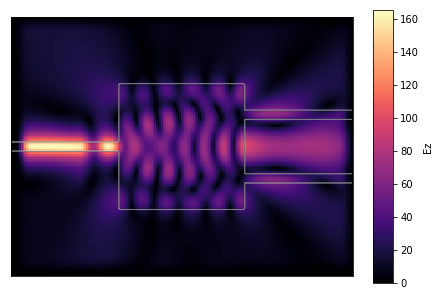

165.17867363807738


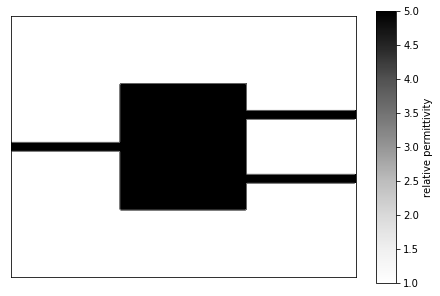

5.0
(50, 1) [[5.78576140e-02]
 [3.60314718e-04]
 [1.63342995e-08]
 [4.20280748e-15]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]]


In [52]:
simulation = Fdfd(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(d/dl), scale=source_amp)
simulation.setup_modes()
(Hx_nl,Hy_nl,Ez_nl,conv) = simulation.solve_fields_nl(nonlin_fns['eps_nl'], regions['nonlin'],
                                                   dnl_de=kerr_nl_de,solver_nl='newton')
simulation.plt_abs()
plt.show()
print(np.max(np.abs(Ez_nl)))
simulation.plt_eps()
plt.show()
print(np.max(np.abs(simulation.eps_r)))
print(conv.shape, conv)